<a href="https://colab.research.google.com/github/xexax/FORECASTING/blob/main/FORECASTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-7-6f6fe83f77c5>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df['month'])


Historical Data Sample:
    product_code      month       sales
132            C 2023-01-01   95.634668
133            C 2023-02-01   93.613666
134            C 2023-03-01  105.443726
135            C 2023-04-01   91.652452
136            C 2023-05-01   99.217318
137            C 2023-06-01   83.515383

Forecast vs Actuals:
   product_code      month    forecast       sales      error  abs_pct_error
0             A 2023-07-01  129.285607  134.053188  -4.767581       3.556485
1             A 2023-08-01  129.285607  141.734439 -12.448831       8.783209
2             A 2023-09-01  129.285607  140.980808 -11.695201       8.295598
3             A 2023-10-01  129.285607  142.494673 -13.209066       9.269867
4             A 2023-11-01  129.285607  153.548930 -24.263323      15.801688
5             A 2023-12-01  129.285607  146.072071 -16.786464      11.491905
6             B 2023-07-01  137.878647   90.174012  47.704634      52.902863
7             B 2023-08-01  137.878647   83.642816  54.235

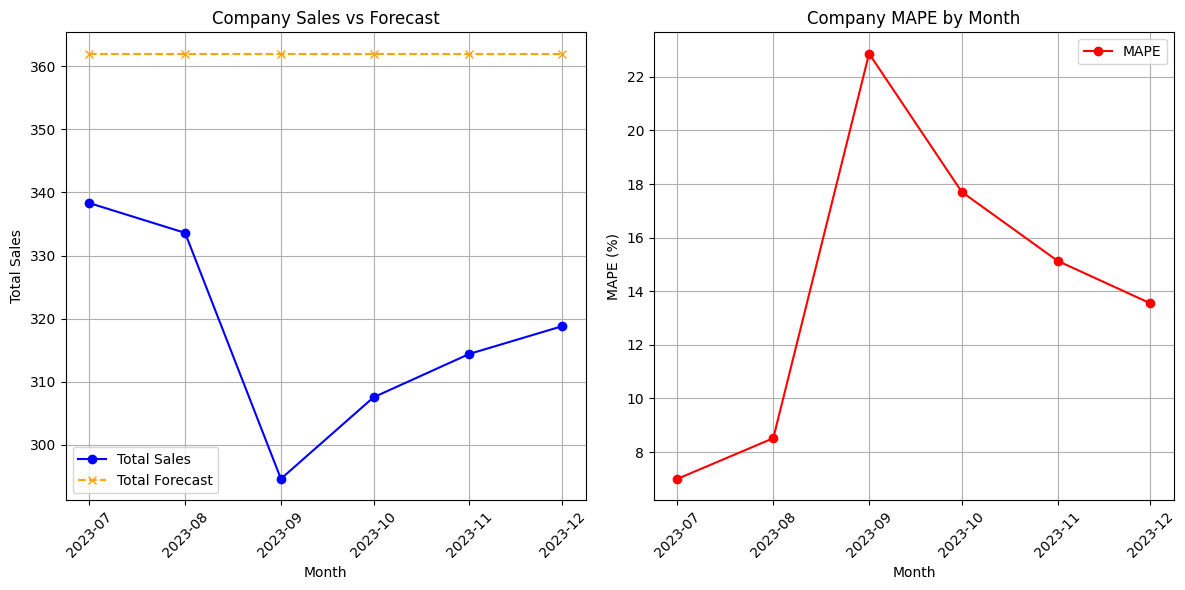

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_synthetic_data():
    """Generate synthetic sales data with trends and seasonality"""
    products = ['A', 'B', 'C']
    dates = pd.date_range(start='2020-01-01', end='2023-12-01', freq='MS')
    n_periods = len(dates)
    sales_data = []

    for product in products:
        for i, date in enumerate(dates):
            if product == 'A':
                # Linear increasing trend
                base = 50 + (100 / n_periods) * i
                sales = base + np.random.normal(0, 5)
            elif product == 'B':
                # Seasonal pattern
                seasonal = 50 * np.sin(2 * np.pi * i / 12)
                sales = 100 + seasonal + np.random.normal(0, 10)
            else:
                # Stable trend with noise
                sales = 100 + np.random.normal(0, 7)
            sales_data.append([product, date, sales])

    return pd.DataFrame(sales_data, columns=['product_code', 'month', 'sales'])

def forecast_pipeline(df):
    """Main forecasting pipeline"""
    # Data preparation
    df['month'] = pd.to_datetime(df['month'])
    df = df.sort_values(['product_code', 'month'])

    # Generate forecasts
    forecast_list = []
    for product in df['product_code'].unique():
        product_data = df[df['product_code'] == product]

        # Calculate 6-month moving average using historical data only
        last_six = product_data[product_data['month'] <= '2023-06-01'].tail(6)['sales']
        forecast_value = last_six.mean()

        # Create forecast dates
        last_date = pd.to_datetime('2023-06-01')
        forecast_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=1),
            periods=6,
            freq='MS'
        )

        # Store forecasts
        for date in forecast_dates:
            forecast_list.append({
                'product_code': product,
                'month': date,
                'forecast': forecast_value
            })

    forecast_df = pd.DataFrame(forecast_list)
    return forecast_df

def calculate_metrics(forecast_df, actuals_df):
    """Calculate bias and MAPE metrics"""
    merged_df = forecast_df.merge(
        actuals_df,
        on=['product_code', 'month'],
        how='left'
    )

    # Calculate error metrics
    merged_df['error'] = merged_df['forecast'] - merged_df['sales']
    merged_df['abs_pct_error'] = (np.abs(merged_df['error']) / merged_df['sales']) * 100

    # Create monthly error metrics table
    monthly_metrics = merged_df.groupby(['product_code', 'month']).agg(
        bias=('error', 'mean'),
        mape=('abs_pct_error', 'mean')
    ).reset_index()

    # Format for better readability
    monthly_metrics['bias'] = monthly_metrics['bias'].round(2)
    monthly_metrics['mape'] = monthly_metrics['mape'].round(2)

    return merged_df, monthly_metrics

def calculate_company_metrics(merged_df):
    """Calculate company-wide aggregated error metrics"""
    # Aggregate sales and forecasts across all products
    company_metrics = merged_df.groupby('month').agg(
        total_sales=('sales', 'sum'),
        total_forecast=('forecast', 'sum')
    ).reset_index()

    # Calculate company-wide error metrics
    company_metrics['error'] = company_metrics['total_forecast'] - company_metrics['total_sales']
    company_metrics['abs_pct_error'] = (np.abs(company_metrics['error']) / company_metrics['total_sales']) * 100

    # Calculate Bias and MAPE
    company_metrics['bias'] = company_metrics['error'].mean()
    company_metrics['mape'] = company_metrics['abs_pct_error'].mean()

    return company_metrics

def visualize_company_metrics(company_metrics):
    """Visualize company-wide error metrics"""
    plt.figure(figsize=(12, 6))

    # Plot total sales vs forecasts
    plt.subplot(1, 2, 1)
    plt.plot(
        company_metrics['month'],
        company_metrics['total_sales'],
        label='Total Sales',
        marker='o',
        color='blue'
    )
    plt.plot(
        company_metrics['month'],
        company_metrics['total_forecast'],
        label='Total Forecast',
        linestyle='--',
        marker='x',
        color='orange'
    )
    plt.title('Company Sales vs Forecast')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # Plot company-wide MAPE (as a line chart)
    plt.subplot(1, 2, 2)
    plt.plot(
        company_metrics['month'],
        company_metrics['abs_pct_error'],
        label='MAPE',
        marker='o',
        color='red'
    )
    plt.title('Company MAPE by Month')
    plt.xlabel('Month')
    plt.ylabel('MAPE (%)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Generate complete dataset
    full_data = generate_synthetic_data()

    # Split into historical and actuals
    historical_data = full_data[full_data['month'] <= '2023-06-01']
    future_actuals = full_data[full_data['month'] > '2023-06-01']

    # Generate forecasts
    forecast_df = forecast_pipeline(historical_data)

    # Calculate metrics
    metrics_df, monthly_metrics = calculate_metrics(forecast_df, future_actuals)

    # Calculate company-wide metrics
    company_metrics = calculate_company_metrics(metrics_df)

    # Show results
    print("Historical Data Sample:")
    print(historical_data.tail(6))

    print("\nForecast vs Actuals:")
    print(metrics_df[['product_code', 'month', 'forecast', 'sales', 'error', 'abs_pct_error']])

    print("\nCompany-Wide Error Metrics:")
    print(company_metrics[['month', 'total_sales', 'total_forecast', 'error', 'abs_pct_error', 'bias', 'mape']])

    # Visualize results
    visualize_company_metrics(company_metrics)